## Analizador Bioimagenes C. elegans - Conteo diferencia de nucleos fluorescentes

#### Cargar Imagenes

Entorno en PC:

readlink -f $(which java)

nano ~/.bashrc  # For bash users
# OR
nano ~/.zshrc   # For zsh users

export JAVA_HOME=/usr/lib/jvm/java-21-openjdk-amd64
export PATH=$JAVA_HOME/bin:$PATH

source ~/.bashrc

pip install python-bioformats

In [28]:
ruta_base = "/home/nephelim/Documentos/Investigacion/Bioimagen_ContadorNucleos/prueba/"
ruta_prueba_1 = ruta_base + "ztf30 1.ids"
img = BioImage(ruta_prueba_1, reader=bioio_bioformats.Reader)
print(type(img))

15:50:44.526 [main] INFO loci.formats.ImageReader - ICSReader initializing /home/nephelim/Documentos/Investigacion/Bioimagen_ContadorNucleos/prueba/ztf30 1.ids
15:50:44.526 [main] DEBUG loci.formats.FormatHandler - ICSReader initializing /home/nephelim/Documentos/Investigacion/Bioimagen_ContadorNucleos/prueba/ztf30 1.ids
15:50:44.526 [main] DEBUG loci.formats.FormatHandler - loci.formats.in.ICSReader.initFile(/home/nephelim/Documentos/Investigacion/Bioimagen_ContadorNucleos/prueba/ztf30 1.ids)
15:50:44.526 [main] INFO loci.formats.FormatHandler - Finding companion file
15:50:44.526 [main] INFO loci.formats.FormatHandler - Checking file version
15:50:44.529 [main] INFO loci.formats.FormatHandler - Reading metadata
15:50:44.583 [main] DEBUG loci.formats.FormatHandler - Could not parse double value 'Confocal C1 Scanner'
java.lang.NumberFormatException: For input string: "Confocal C1 Scanner"
	at java.base/jdk.internal.math.FloatingDecimal.readJavaFormatString(Unknown Source)
	at java.base

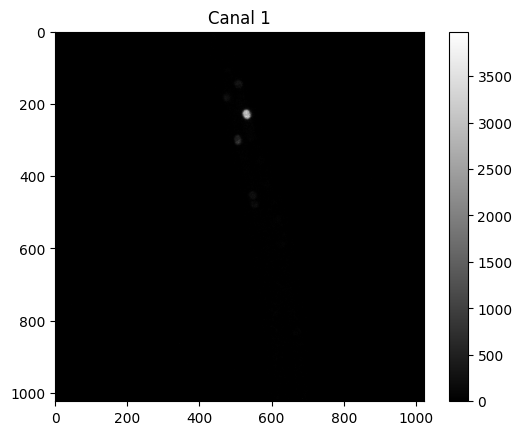

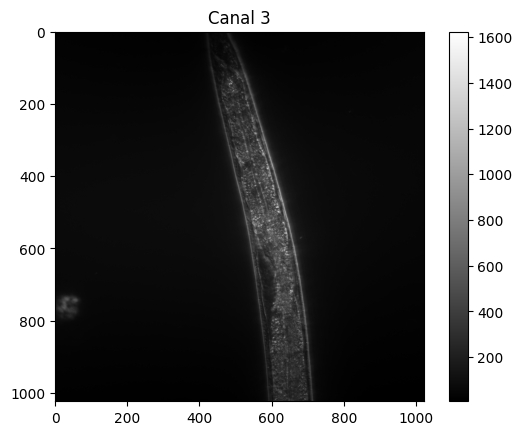

In [30]:
import matplotlib.pyplot as plt

def esImpar(i):
    return i%2 != 0

for i in range(arr.shape[0]):
    if (esImpar(i)):
        plt.figure()
        plt.imshow(arr[i], cmap="gray")
        plt.title(f"Canal {i}")
        plt.colorbar()
        plt.show()


In [ ]:
from bioio import BioImage 
import bioio_bioformats
import numpy as np  
import pandas as pd 

class BioImageHandler:
    '''
        Clase para la manipulación y procesamiento de imagenes biológicas de microscopía, en particular, confocal de fluorescencia.
        La imagen según su formato es convertida a una matriz de tipo compatible según escala de grises. Los analisis se realizan particularmente en tipo uint8.
        Se requiere Java para el empleo de bioio_bioformats. 
    '''
    
    def __init__(self, rutaImagen):
        self.rutaImagen = rutaImagen # Nota , algunos formatos pueden requerir tener sus metadatos en la propia carpeta con el mismo nombre.
        self.img = None # Array uni o multidimensional.
        self.imgArrays = None 
        self.imgMatrizActual = None
    
    def leerBioImagen_bioformats(self):
        # Funcion que transforma una iamgen cargada por su ruta en su Array multidimensional según si es una pila de imagenes o no. 
        
        try:
            img = BioImage(self.rutaImagen, reader=bioio_bioformats.Reader)
            self.img = img.data
            return img.data
        except Exception as e:
            print(f"Error al leer la imagen: {e}")
            return None
    
    def tipoArrayImagen(self, img = None):
        # Indica el tipo de int del Array que conforma a la imagen
        if img is None:
            img = self.img
        
        return type(img) 
    
    def obtenerImagenesArray(self, img = None):
        # Recibe un tipo Array multidimensional y lo desarma en una lista de Arrays de facil acceso por índice. 
        # Suelen corresponder a los canales del microscopio 
        # Retorna el puntero a dichos arrays y el tipo del mismo.
        
        if img is None:
            img = self.img
        
        imgArrays = img.squeeze()  # Desenrolla la imagen si es necesario
        self.imgArrays = imgArrays  # Guardamos los arrays de la imagen
        return imgArrays, imgArrays.shape
    
    def convertirImgArray_AMAtriz(self, imgArray):
        # Convierte un array de una imagen de tipo uintx a una matriz del mismo tipo
        
        matriz_imagen = np.array(imgArray)
        self.imgMatrizActual = matriz_imagen
        
        return matriz_imagen
    
    def normalizarImgMatriz(self, imgMatriz = None):
        # Normaliza una matriz que representa una imagen. 
        # Nota: Actualiza la matriz guardada en la clase
        
        if imgMatriz is None:
            imgMatriz = self.imgMatrizActual
        
        dtype = imgMatriz.dtype
        max_valor = np.iinfo(dtype).max
        matriz_img_norm = imgMatriz / max_valor  # Esto lo normaliza pero lo deja en flotante
        self.imgMatrizActual = matriz_img_norm
        return matriz_img_norm
    
    def binarizarImgMatrizNorm(self, imgMatriz = None, threshold = 0.5):
        # Dada una matriz normalizada , la binariza (transforma a 0 y 1) dado cierto threshold para la señal. 
        
        if imgMatriz is None:
            imgMatriz = self.imgMatrizActual
        
        imgBinMatriz = imgMatriz.copy()
        imgBinMatriz[imgMatriz > threshold] = 1
        imgBinMatriz[imgMatriz <= threshold] = 0
        imgBinMatriz = imgBinMatriz.astype(np.uint8)
        self.imgMatrizActual = imgBinMatriz
        return imgBinMatriz

NameError: name 'self' is not defined